# Part II: Investigating the Vanishing Gradient Problem [20 pts]
Experimentally demonstrate the vanishing gradient problem in deep CNNs and understand how ResNet's architecture mitigates it. You will also explore other key CNN concepts through additional experiments.

In [2]:
import os
import torch
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from torch.utils.data import Subset
from torchsummary import summary

In [4]:
!unzip cnn_dataset.zip -d /content/cnn_dataset/
dataset_path = "/content/cnn_dataset"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
class_names = dataset.classes
class_counts = Counter([dataset.targets[i] for i in range(len(dataset))])
df = pd.DataFrame({'Class': class_names, 'Image Count': [class_counts[i] for i in range(len(class_names))]})
print(f"Total Images: {len(dataset)}")
print(f"Number of Classes: {len(class_names)}")
print("\nClass Distribution:\n", df)

'unzip' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/cnn_dataset'

In [ ]:
targets = torch.LongTensor(dataset.targets)

In [ ]:
indices = np.arange(len(dataset))
train_idx, test_val_idx = train_test_split(indices, test_size=0.3, stratify=dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_val_idx], random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 21000 images
Validation set: 4500 images
Test set: 4500 images


## Step 1: Create a deeper version of your VGG-16 network (VGG-Deep)

In [ ]:
class VGG_Deep_model(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG_Deep_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
iteration_counter = 0
grad_norms_dict = {}

In [ ]:
def gradient_hook(module, grad_input, grad_output):
    global iteration_counter, grad_norms_dict
    if iteration_counter % 10 == 0:
        if module.weight.grad is not None:
            norm_value = module.weight.grad.clone().detach().norm(p=2).item()
        else:
            norm_value = 0.0
        grad_norms_dict[module.layer_id].append((iteration_counter, norm_value))


In [ ]:
def grad_hook_method(grad, layer_id):
    global iteration_counter, grad_norms_dict
    if iteration_counter % 10 == 0:
        norm_value = grad.detach().clone().norm(p=2).item()
        grad_norms_dict[layer_id].append((iteration_counter, norm_value))
    return grad

In [ ]:
def register_gradient_hooks(model):
    global grad_norms_dict
    layer_idx = 0

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            module.layer_id = f"conv_{layer_idx}"
            grad_norms_dict[module.layer_id] = []
            module.weight.register_hook(lambda grad, layer_id=module.layer_id: grad_hook_method(grad, layer_id))
            layer_idx += 1

## Step 2: Training VGG-Deep

In [ ]:
def kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
def run_an_epoch(model, dataloader, criterion, optimizer, device):
    global iteration_counter
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        iteration_counter += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
def evaluate_an_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

<span style='color:green'>### YOUR ANSWER ###</span>

In [ ]:
def train_function(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        train_loss, train_acc = run_an_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}\n")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def plot_training_graphs(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, title=''):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def test_function(model, test_loader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

In [ ]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [ ]:
print("=" * 60)
print("Training VGG-Deep (deeper network without dropout/regularization)")
print("=" * 60)
iteration_counter = 0
grad_norms_dict = {}
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
b_size = 32
train_loader, val_loader, test_loader = create_dataloaders(b_size)
deep_model = VGG_Deep_model(num_classes=num_classes).to(device)
deep_model.apply(kaiming)
register_gradient_hooks(deep_model)
criterion_deep = nn.CrossEntropyLoss()
optimizer_deep = optim.SGD(deep_model.parameters(), lr=0.01)
start_time = time.time()
trained_model_deep, train_losses_deep, train_accuracies_deep, val_losses_deep, val_accuracies_deep = train_function(
    deep_model, train_loader, val_loader, criterion_deep, optimizer_deep, device, num_epochs=10)
plot_training_graphs(train_losses_deep, val_losses_deep, train_accuracies_deep, val_accuracies_deep, num_epochs=10,
                     title='VGG-Deep')
test_acc_deep = test_function(trained_model_deep, test_loader, device)
print(f"Test Accuracy (VGG-Deep): {test_acc_deep:.4f}")

Training VGG-Deep (deeper network without dropout/regularization)
Using device: cuda
Epoch 1/10
----------
Train Loss: 0.7874 Acc: 0.6537
Val   Loss: 0.9204 Acc: 0.5673

Epoch 2/10
----------
Train Loss: 0.4944 Acc: 0.8022
Val   Loss: 0.7915 Acc: 0.6396

Epoch 3/10
----------


In [ ]:
print(train_accuracies_deep)
print(train_losses_deep)
print(val_accuracies_deep)
print(val_losses_deep)

[0.6515714285714286, 0.8091428571428572, 0.8379047619047619, 0.8592857142857143, 0.8766190476190476, 0.8884761904761905, 0.9004761904761905, 0.9090476190476191, 0.9186666666666667, 0.9263809523809524]
[0.7826494984853836, 0.47518528811136884, 0.4080631155172984, 0.357941057068961, 0.3198741649048669, 0.2884391134863808, 0.2631212267222859, 0.23532079697222938, 0.21898141844215846, 0.19561566564724558]
[0.788, 0.794888888888889, 0.6635555555555556, 0.7120000000000001, 0.8237777777777778, 0.7897777777777778, 0.888888888888889, 0.5144444444444445, 0.8564444444444445, 0.7795555555555556]
[0.5289191660881043, 0.46708281559414333, 0.7998210484186808, 0.6713043349583944, 0.42295995389090646, 0.5356453800201416, 0.29366873876253763, 1.2778390267690023, 0.38838451393445333, 0.6389972794850667]


## Step 3: Gradient analysis

- Track the average L2 norm of the gradients in each convolutional layer using PyTorch hooks.

- Create a plot showing the average gradient norm for each convolutional layer over time.

In [ ]:
def plot_norms(grad_norms_dict):
    plt.figure(figsize=(12, 6))

    for layer_id, data in grad_norms_dict.items():
        if data:
            iterations, norms = zip(*data)
            plt.plot(iterations, norms, label=layer_id)

    plt.xlabel("Iteration")
    plt.ylabel("Gradient L2 Norm")
    plt.title("Gradient Norms for All Convolutional Layers")
    plt.legend()
    plt.show()
    selected_layers = []
    keys = sorted(grad_norms_dict.keys(), key=lambda x: int(x.split('_')[1]))
    if len(keys) > 0:
        if len(keys) > 1:
            selected_layers.append(keys[1])
        if len(keys) > 4:
            selected_layers.append(keys[4])
        if len(keys) > 7:
            selected_layers.append(keys[7])
        selected_layers.append(keys[-1])
    plt.figure(figsize=(12, 6))

    for layer_id in selected_layers:
        data = grad_norms_dict[layer_id]
        if data:
            iterations, norms = zip(*data)
            plt.plot(iterations, norms, label=layer_id)

    plt.xlabel("Iteration")
    plt.ylabel("Gradient L2 Norm")
    plt.title("Gradient Norms for Selected Convolutional Layers")
    plt.legend()
    plt.show()


Plotting Gradient Norms for VGG-Deep...


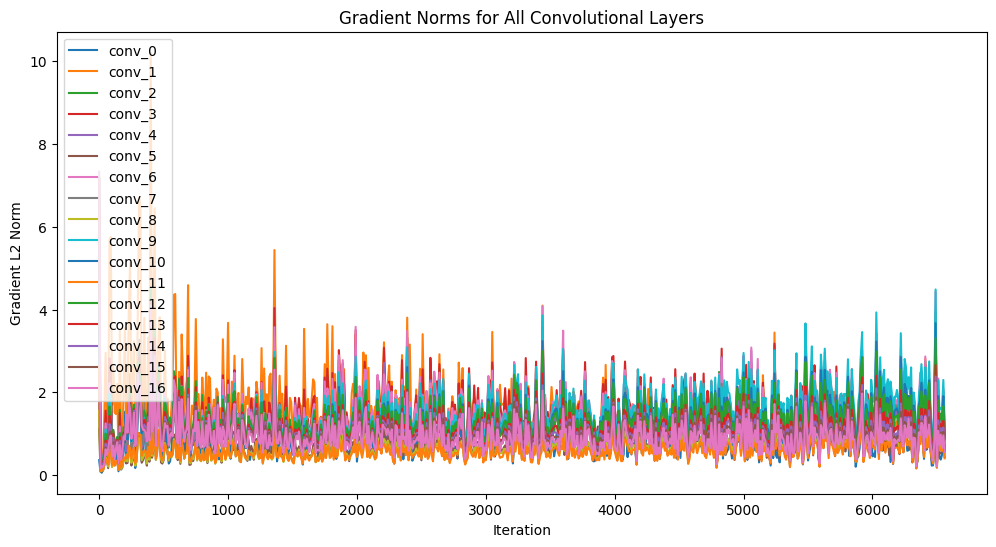

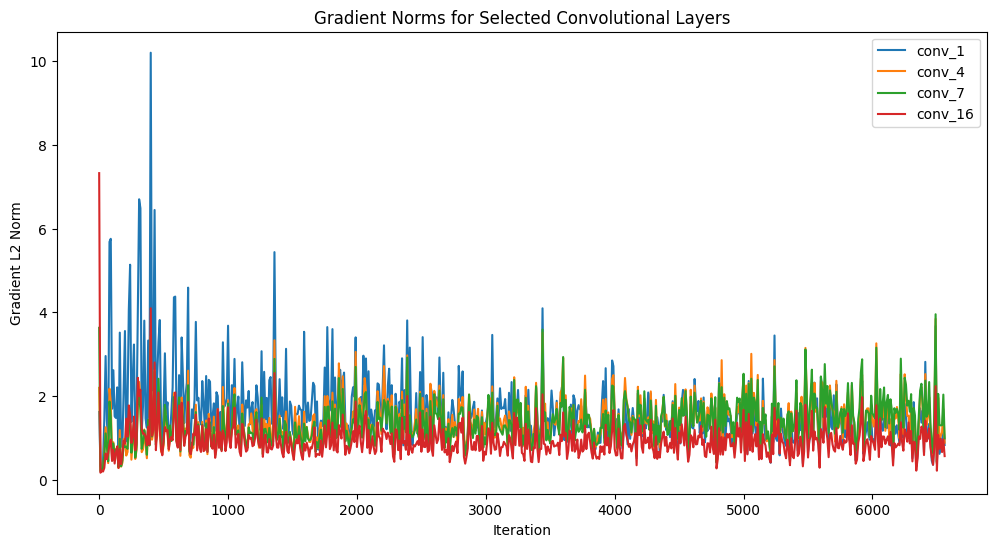

In [ ]:
print("\nPlotting Gradient Norms for VGG-Deep...")
plot_norms(grad_norms_dict)

- Create a separate plot showing the gradient norms for a subset of layers.

In [ ]:
### ADD YOUR CODE HERE ###

<span style='color:green'>### YOUR ANSWER ###</span>

## Step 4: Comparison with VGG-16 and ResNet-18

- Compare the training curves (loss and accuracy vs. epoch) of VGG-Deep, VGG-16, and ResNet-18.

In [ ]:
### ADD YOUR CODE HERE ###

- Discuss how ResNet’s residual connections impact the gradient flow compared to VGG-Deep.

<span style='color:green'>### YOUR ANSWER ###</span>

## Step 5: Investigate and analyze more setups

- Select any THREE experiments to investigate and analyze.

### Experiment 1

In [ ]:
def train_an_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
def validate_an_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

In [ ]:
def train_the_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_an_epoch(model, train_loader, criterion, optimizer, device)
        scheduler.step()
        val_loss, val_acc = validate_an_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}  Acc: {val_acc:.4f}\n")
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}\n")
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def test_the_model(model, test_loader, device):
    model.eval()
    running_corrects = 0

    with torch.no_grad():

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

In [ ]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, title=''):
    epochs = range(1, num_epochs+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Acc')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [ ]:
class Small_VGG_model(nn.Module):
    def __init__(self, kernel_size=3, num_classes=3):
        super(Small_VGG_model, self).__init__()
        padding = (kernel_size - 1) // 2
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
train_loader, val_loader, test_loader = create_dataloaders(b_size)

Using device: cuda
Experiment a: Impact of Kernel Size

Training SmallVGG with 3x3 kernels
Epoch 1/10
Train Loss: 0.5637  Acc: 0.7650
Val   Loss: 0.4144  Acc: 0.8396

Epoch 2/10
Train Loss: 0.3837  Acc: 0.8510
Val   Loss: 0.5014  Acc: 0.7969

Epoch 3/10
Train Loss: 0.3216  Acc: 0.8790
Val   Loss: 0.3477  Acc: 0.8716

Epoch 4/10
Train Loss: 0.2725  Acc: 0.8981
Val   Loss: 0.3358  Acc: 0.8722

Epoch 5/10
Train Loss: 0.2433  Acc: 0.9076
Val   Loss: 0.2781  Acc: 0.8967

Epoch 6/10
Train Loss: 0.1809  Acc: 0.9351
Val   Loss: 0.2311  Acc: 0.9167

Epoch 7/10
Train Loss: 0.1690  Acc: 0.9370
Val   Loss: 0.2322  Acc: 0.9167

Epoch 8/10
Train Loss: 0.1631  Acc: 0.9400
Val   Loss: 0.2315  Acc: 0.9189

Epoch 9/10
Train Loss: 0.1587  Acc: 0.9420
Val   Loss: 0.2340  Acc: 0.9187

Epoch 10/10
Train Loss: 0.1543  Acc: 0.9441
Val   Loss: 0.2361  Acc: 0.9167

Training complete in 4m 19s
Best val Acc: 0.9189

Test Accuracy: 0.9240


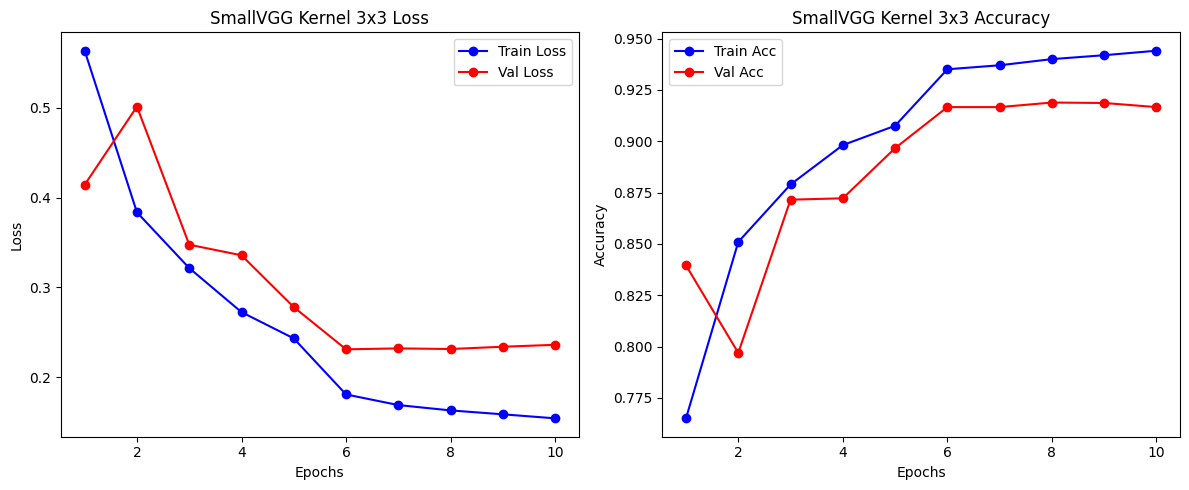


Training SmallVGG with 5x5 kernels
Epoch 1/10
Train Loss: 0.5736  Acc: 0.7640
Val   Loss: 0.4756  Acc: 0.8136

Epoch 2/10
Train Loss: 0.3770  Acc: 0.8537
Val   Loss: 0.3781  Acc: 0.8516

Epoch 3/10
Train Loss: 0.3066  Acc: 0.8850
Val   Loss: 0.2856  Acc: 0.8942

Epoch 4/10
Train Loss: 0.2601  Acc: 0.9005
Val   Loss: 0.2538  Acc: 0.9049

Epoch 5/10
Train Loss: 0.2261  Acc: 0.9161
Val   Loss: 0.2338  Acc: 0.9140

Epoch 6/10
Train Loss: 0.1566  Acc: 0.9427
Val   Loss: 0.2112  Acc: 0.9249

Epoch 7/10
Train Loss: 0.1417  Acc: 0.9494
Val   Loss: 0.2157  Acc: 0.9231

Epoch 8/10
Train Loss: 0.1337  Acc: 0.9517
Val   Loss: 0.2101  Acc: 0.9238

Epoch 9/10
Train Loss: 0.1277  Acc: 0.9539
Val   Loss: 0.2054  Acc: 0.9269

Epoch 10/10
Train Loss: 0.1205  Acc: 0.9568
Val   Loss: 0.2055  Acc: 0.9258

Training complete in 4m 36s
Best val Acc: 0.9269

Test Accuracy: 0.9316


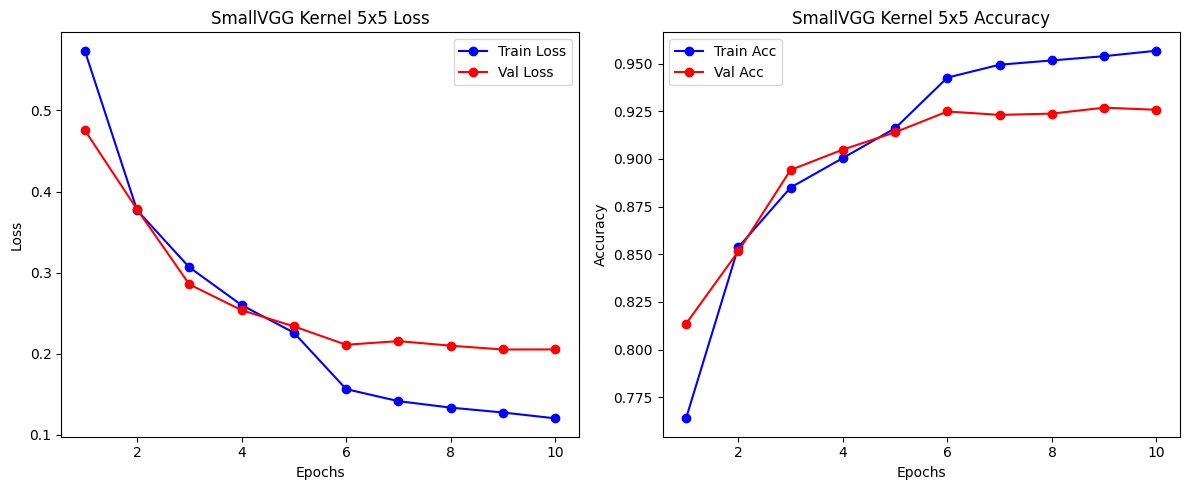


Training SmallVGG with 7x7 kernels
Epoch 1/10
Train Loss: 0.6110  Acc: 0.7431
Val   Loss: 0.4751  Acc: 0.8149

Epoch 2/10
Train Loss: 0.4157  Acc: 0.8393
Val   Loss: 0.4567  Acc: 0.8229

Epoch 3/10
Train Loss: 0.3442  Acc: 0.8668
Val   Loss: 0.3301  Acc: 0.8753

Epoch 4/10
Train Loss: 0.3041  Acc: 0.8840
Val   Loss: 0.3019  Acc: 0.8827

Epoch 5/10
Train Loss: 0.2544  Acc: 0.9030
Val   Loss: 0.2721  Acc: 0.8951

Epoch 6/10
Train Loss: 0.1765  Acc: 0.9342
Val   Loss: 0.2393  Acc: 0.9131

Epoch 7/10
Train Loss: 0.1597  Acc: 0.9410
Val   Loss: 0.2405  Acc: 0.9136

Epoch 8/10
Train Loss: 0.1500  Acc: 0.9450
Val   Loss: 0.2413  Acc: 0.9133

Epoch 9/10
Train Loss: 0.1419  Acc: 0.9492
Val   Loss: 0.2372  Acc: 0.9151

Epoch 10/10
Train Loss: 0.1325  Acc: 0.9512
Val   Loss: 0.2391  Acc: 0.9180

Training complete in 7m 8s
Best val Acc: 0.9180

Test Accuracy: 0.9182


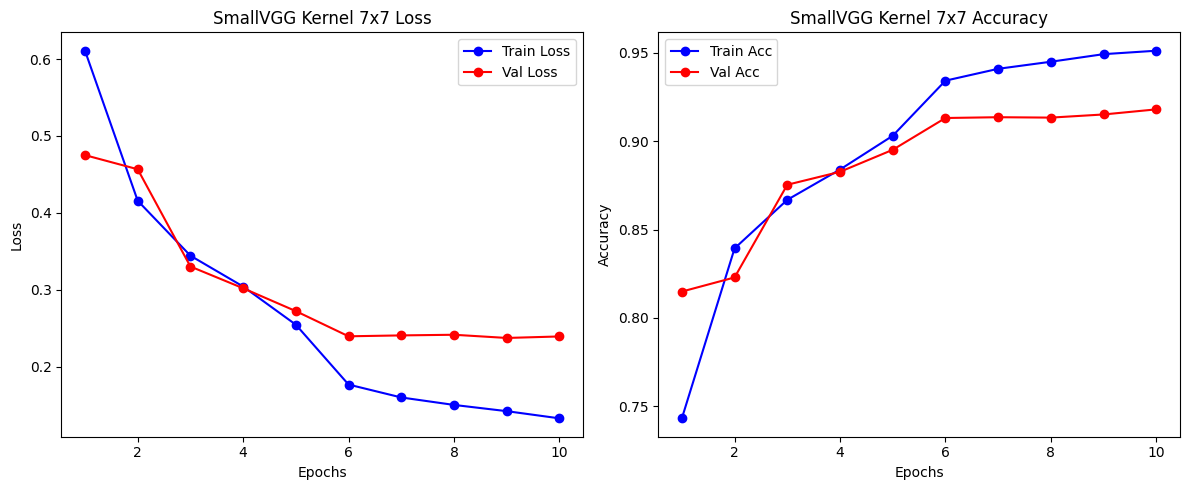

Kernel Size Experiment Results: {'kernel_3': 0.924, 'kernel_5': 0.9315555555555556, 'kernel_7': 0.9182222222222223}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
print("="*60)
print("Experiment a: Impact of Kernel Size")
print("="*60)
models_kernel = {}

for k in [3, 5, 7]:
    print(f"\nTraining SmallVGG with {k}x{k} kernels")
    model_k = Small_VGG_model(kernel_size=k, num_classes=num_classes).to(device)
    model_k.apply(kaiming)
    optimizer_k = optim.SGD(model_k.parameters(), lr=0.01, momentum=0.9)
    scheduler_k = lr_scheduler.StepLR(optimizer_k, step_size=5, gamma=0.1)
    model_k, train_losses_k, train_accs_k, val_losses_k, val_accs_k = train_the_model(
        model_k, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_k, scheduler_k, device, num_epochs=10)
    test_acc_k = test_the_model(model_k, test_loader, device)
    models_kernel[f'kernel_{k}'] = test_acc_k.item()
    plot_training_curves(train_losses_k, val_losses_k, train_accs_k, val_accs_k, num_epochs=10,
                         title=f'SmallVGG Kernel {k}x{k}')
print("Kernel Size Experiment Results:", models_kernel)

<span style='color:green'>### YOUR ANSWER ###</span>

### Experiment 2

In [ ]:
class Small_VGG_model_with_1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_with_1x1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Small_VGG_model_without_1x1(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_without_1x1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



Experiment b: Impact of 1x1 Convolutions

Training model WITH 1x1 convolutions
Epoch 1/10
Train Loss: 0.6007  Acc: 0.7479
Val   Loss: 0.5328  Acc: 0.7864

Epoch 2/10
Train Loss: 0.4444  Acc: 0.8196
Val   Loss: 0.4292  Acc: 0.8389

Epoch 3/10
Train Loss: 0.3899  Acc: 0.8446
Val   Loss: 0.3606  Acc: 0.8662

Epoch 4/10
Train Loss: 0.3487  Acc: 0.8650
Val   Loss: 0.3733  Acc: 0.8620

Epoch 5/10
Train Loss: 0.3139  Acc: 0.8784
Val   Loss: 0.2904  Acc: 0.8907

Epoch 6/10
Train Loss: 0.2459  Acc: 0.9083
Val   Loss: 0.2746  Acc: 0.8976

Epoch 7/10
Train Loss: 0.2361  Acc: 0.9111
Val   Loss: 0.2696  Acc: 0.9018

Epoch 8/10
Train Loss: 0.2303  Acc: 0.9130
Val   Loss: 0.2652  Acc: 0.9029

Epoch 9/10
Train Loss: 0.2244  Acc: 0.9172
Val   Loss: 0.2644  Acc: 0.9024

Epoch 10/10
Train Loss: 0.2210  Acc: 0.9187
Val   Loss: 0.2597  Acc: 0.9051

Training complete in 4m 18s
Best val Acc: 0.9051

Test Accuracy: 0.9078


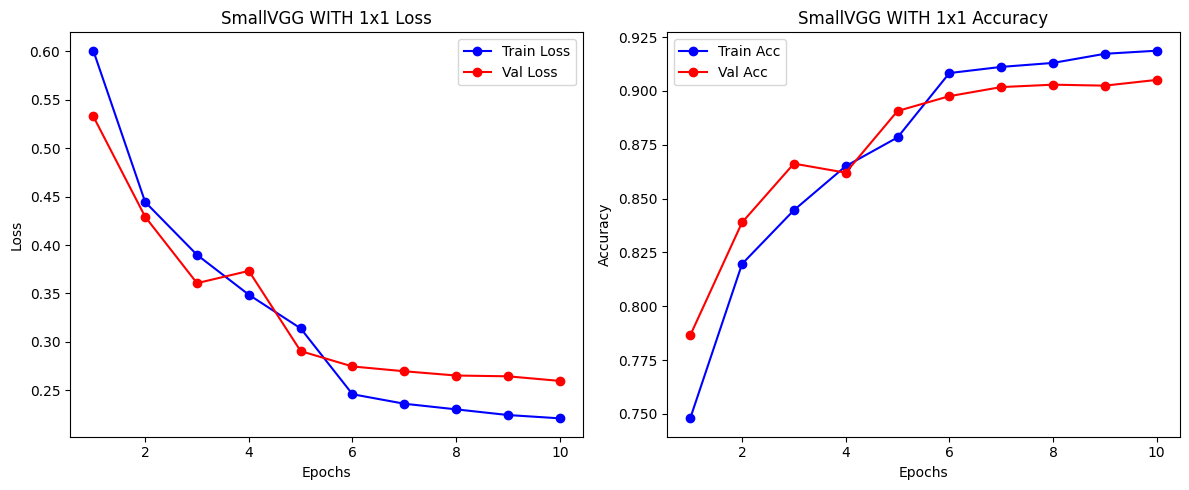


Parameter count for model WITH 1x1:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           1,056
              ReLU-4         [-1, 32, 128, 128]               0
         MaxPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
 AdaptiveAvgPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 128]         131,200
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 3]             387
Total params: 152,035
Trainable params: 152,035
Non-trainable para

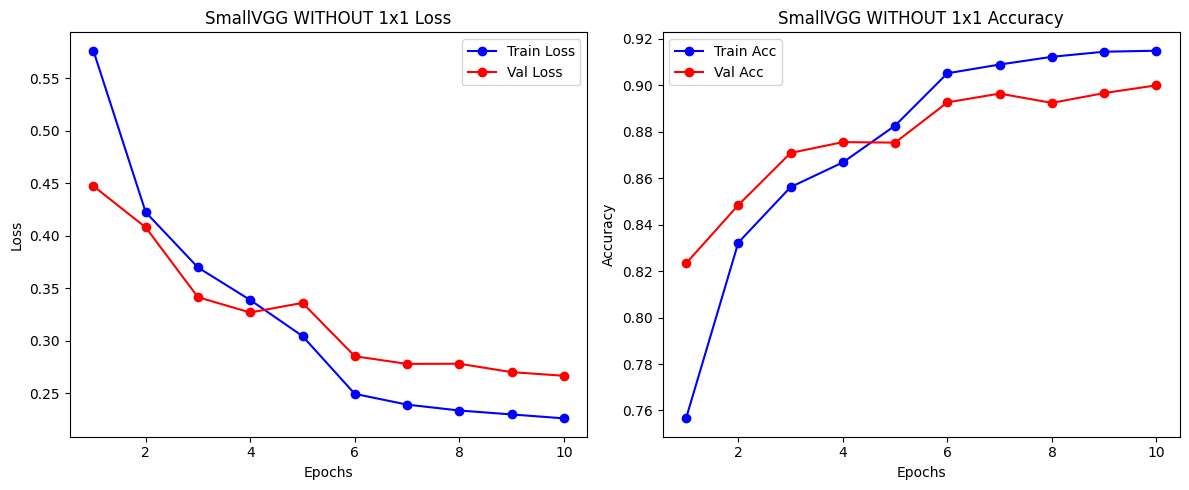


Parameter count for model WITHOUT 1x1:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 64, 4, 4]               0
            Linear-8                  [-1, 128]         131,200
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 3]             387
Total params: 150,979
Trainable params: 150,979
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB):

In [ ]:
print("\n" + "="*60)
print("Experiment b: Impact of 1x1 Convolutions")
print("="*60)
print("\nTraining model WITH 1x1 convolutions")
model_with_1x1 = Small_VGG_model_with_1x1(num_classes=num_classes).to(device)
model_with_1x1.apply(kaiming)
optimizer_with = optim.SGD(model_with_1x1.parameters(), lr=0.01, momentum=0.9)
scheduler_with = lr_scheduler.StepLR(optimizer_with, step_size=5, gamma=0.1)
model_with_1x1, train_losses_with, train_accs_with, val_losses_with, val_accs_with = train_the_model(
    model_with_1x1, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_with, scheduler_with, device, num_epochs=10)
test_acc_with = test_the_model(model_with_1x1, test_loader, device)
plot_training_curves(train_losses_with, val_losses_with, train_accs_with, val_accs_with, num_epochs=10,
                     title='SmallVGG WITH 1x1')
print("\nParameter count for model WITH 1x1:")
summary(model_with_1x1, input_size=(3,128,128))
print("\nTraining model WITHOUT 1x1 convolutions")
model_without_1x1 = Small_VGG_model_without_1x1(num_classes=num_classes).to(device)
model_without_1x1.apply(kaiming)
optimizer_without = optim.SGD(model_without_1x1.parameters(), lr=0.01, momentum=0.9)
scheduler_without = lr_scheduler.StepLR(optimizer_without, step_size=5, gamma=0.1)
model_without_1x1, train_losses_without, train_accs_without, val_losses_without, val_accs_without = train_the_model(
    model_without_1x1, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_without, scheduler_without, device, num_epochs=10)
test_acc_without = test_the_model(model_without_1x1, test_loader, device)
plot_training_curves(train_losses_without, val_losses_without, train_accs_without, val_accs_without, num_epochs=10,
                     title='SmallVGG WITHOUT 1x1')
print("\nParameter count for model WITHOUT 1x1:")
summary(model_without_1x1, input_size=(3,128,128))


<span style='color:green'>### YOUR ANSWER ###</span>

### Experiment 3

In [ ]:
class Small_VGG_model_MaxPool(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_MaxPool, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Small_VGG_model_AvgPool(nn.Module):
    def __init__(self, num_classes=3):
        super(Small_VGG_model_AvgPool, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Experiment c: Max Pooling vs. Average Pooling

Training model with Max Pooling
Epoch 1/10
Train Loss: 0.5642  Acc: 0.7612
Val   Loss: 0.7308  Acc: 0.7142

Epoch 2/10
Train Loss: 0.4263  Acc: 0.8316
Val   Loss: 0.3863  Acc: 0.8527

Epoch 3/10
Train Loss: 0.3701  Acc: 0.8537
Val   Loss: 0.3478  Acc: 0.8707

Epoch 4/10
Train Loss: 0.3304  Acc: 0.8714
Val   Loss: 0.3338  Acc: 0.8724

Epoch 5/10
Train Loss: 0.3050  Acc: 0.8840
Val   Loss: 0.3002  Acc: 0.8884

Epoch 6/10
Train Loss: 0.2462  Acc: 0.9084
Val   Loss: 0.2758  Acc: 0.8978

Epoch 7/10
Train Loss: 0.2350  Acc: 0.9129
Val   Loss: 0.2684  Acc: 0.9038

Epoch 8/10
Train Loss: 0.2286  Acc: 0.9160
Val   Loss: 0.2729  Acc: 0.9031

Epoch 9/10
Train Loss: 0.2250  Acc: 0.9176
Val   Loss: 0.2640  Acc: 0.9062

Epoch 10/10
Train Loss: 0.2214  Acc: 0.9175
Val   Loss: 0.2590  Acc: 0.9047

Training complete in 3m 60s
Best val Acc: 0.9062

Test Accuracy: 0.9107


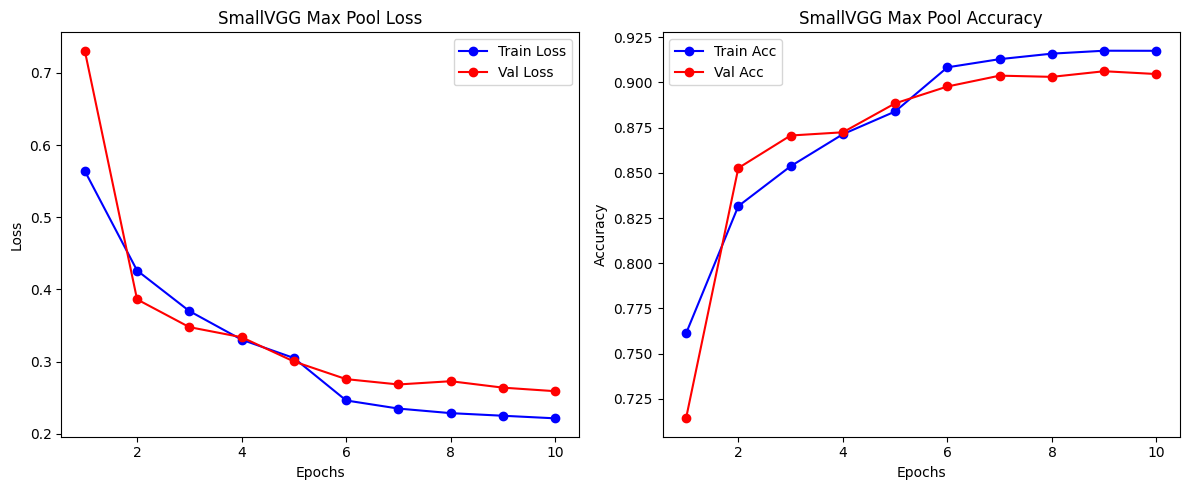


Training model with Average Pooling
Epoch 1/10
Train Loss: 0.6515  Acc: 0.7160
Val   Loss: 0.5160  Acc: 0.7933

Epoch 2/10
Train Loss: 0.4853  Acc: 0.8005
Val   Loss: 0.4363  Acc: 0.8298

Epoch 3/10
Train Loss: 0.4244  Acc: 0.8324
Val   Loss: 0.4147  Acc: 0.8253

Epoch 4/10
Train Loss: 0.3809  Acc: 0.8505
Val   Loss: 0.3797  Acc: 0.8478

Epoch 5/10
Train Loss: 0.3534  Acc: 0.8626
Val   Loss: 0.3609  Acc: 0.8633

Epoch 6/10
Train Loss: 0.2898  Acc: 0.8898
Val   Loss: 0.3275  Acc: 0.8727

Epoch 7/10
Train Loss: 0.2799  Acc: 0.8927
Val   Loss: 0.3219  Acc: 0.8776

Epoch 8/10
Train Loss: 0.2752  Acc: 0.8946
Val   Loss: 0.3182  Acc: 0.8796

Epoch 9/10
Train Loss: 0.2708  Acc: 0.8969
Val   Loss: 0.3169  Acc: 0.8793

Epoch 10/10
Train Loss: 0.2669  Acc: 0.8987
Val   Loss: 0.3174  Acc: 0.8773

Training complete in 3m 59s
Best val Acc: 0.8796

Test Accuracy: 0.8898


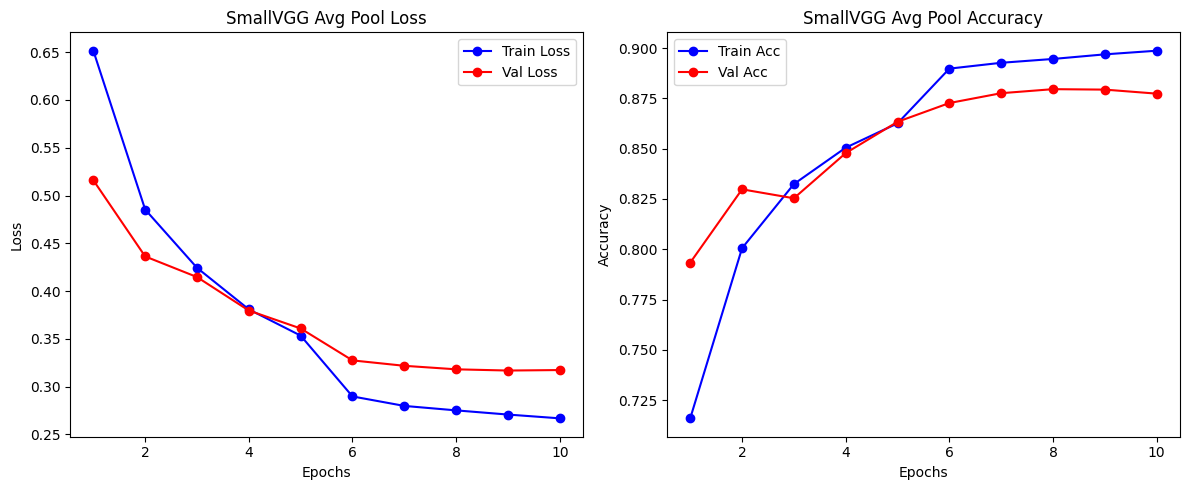


Test Accuracy (Max Pool): 0.9106666666666667
Test Accuracy (Avg Pool): 0.8897777777777778


In [ ]:
print("\n" + "="*60)
print("Experiment c: Max Pooling vs. Average Pooling")
print("="*60)
print("\nTraining model with Max Pooling")
model_maxpool = Small_VGG_model_MaxPool(num_classes=num_classes).to(device)
model_maxpool.apply(kaiming)
optimizer_max = optim.SGD(model_maxpool.parameters(), lr=0.01, momentum=0.9)
scheduler_max = lr_scheduler.StepLR(optimizer_max, step_size=5, gamma=0.1)
model_maxpool, train_losses_max, train_accs_max, val_losses_max, val_accs_max = train_the_model(
    model_maxpool, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_max, scheduler_max, device, num_epochs=10)
test_acc_max = test_the_model(model_maxpool, test_loader, device)
plot_training_curves(train_losses_max, val_losses_max, train_accs_max, val_accs_max, num_epochs=10,
                     title='SmallVGG Max Pool')
print("\nTraining model with Average Pooling")
model_avgpool = Small_VGG_model_AvgPool(num_classes=num_classes).to(device)
model_avgpool.apply(kaiming)
optimizer_avg = optim.SGD(model_avgpool.parameters(), lr=0.01, momentum=0.9)
scheduler_avg = lr_scheduler.StepLR(optimizer_avg, step_size=5, gamma=0.1)
model_avgpool, train_losses_avg, train_accs_avg, val_losses_avg, val_accs_avg = train_the_model(
    model_avgpool, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_avg, scheduler_avg, device, num_epochs=10)
test_acc_avg = test_the_model(model_avgpool, test_loader, device)
plot_training_curves(train_losses_avg, val_losses_avg, train_accs_avg, val_accs_avg, num_epochs=10,
                     title='SmallVGG Avg Pool')
print("\nTest Accuracy (Max Pool):", test_acc_max.item())
print("Test Accuracy (Avg Pool):", test_acc_avg.item())

<span style='color:green'>### YOUR ANSWER ###</span>

## Step 6: Analysis and discussion

a. Analyze your gradient norm plots. Do they demonstrate the vanishing gradient problem? Explain how the gradient norm changes as you move deeper into VGG-Deep. Be specific and quantitative (e.g., "The gradient norm of layer 2 is X times larger than the gradient norm of layer 10").

<span style='color:green'>### YOUR ANSWER ###</span>

b. Explain why the vanishing gradient problem occurs in deep networks. Relate this to the backpropagation algorithm and the chain rule. Discuss how the repeated multiplication of small gradients can lead to extremely small values in earlier layers.

<span style='color:green'>### YOUR ANSWER ###</span>

c. Explain how ResNet's architecture (residual connections) helps alleviate the vanishing gradient problem. Explain how the identity mapping allows gradients to flow more easily through the network.

<span style='color:green'>### YOUR ANSWER ###</span>

d. Discuss the theoretical impact of batch normalization on the vanishing/exploding gradient problem. Explain how it helps stabilize and accelerate training.

<span style='color:green'>### YOUR ANSWER ###</span>

e. Summarize the key findings from your three chosen investigations.

<span style='color:green'>### YOUR ANSWER ###</span>

f. References. Include details on all the resources used to complete this part.

<span style='color:green'>### YOUR ANSWER ###</span>